# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Authors:** Diego Canton, Sebastien Emery and Pauline Heusghem <br>
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

#  Needed packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.io

from scipy import ndimage as ndi
from skimage import exposure
from skimage import feature
from skimage import filters
from skimage import morphology
from skimage import util
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_yen, threshold_minimum, threshold_otsu, threshold_multiotsu
from skimage.measure import label
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, square, star, rectangle, disk
from skimage.segmentation import flood, flood_fill, morphological_chan_vese, chan_vese, circle_level_set, checkerboard_level_set

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

##### Display the image and the histogramm

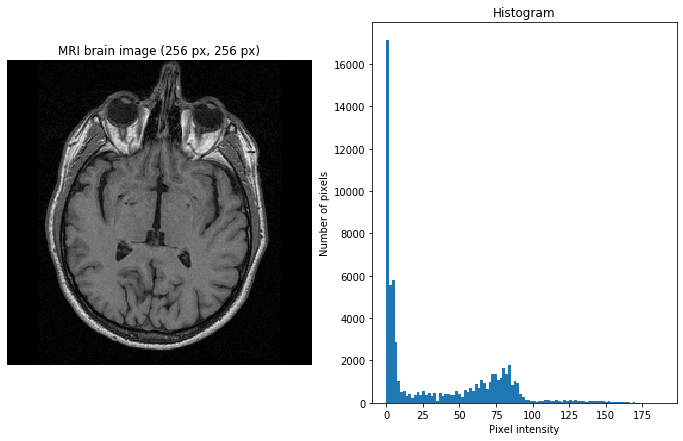

In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape


fig, ax = plt.subplots(1, 2, figsize=(12, 7))

# Display the image
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')

# Display the associated grayscale histogram
ax[1].hist(brain_im.ravel(), bins=100)
ax[1].set_title('Histogram')
ax[1].set_xlabel('Pixel intensity')
ax[1].set_ylabel('Number of pixels')

plt.show()

By looking first at the histogram distribution of gray levels, we can distinguish approximatively two peaks. The first one at zero and nearby corresponds to the black pixels on the image which is the background, the second is mainly situated between 50-100 and is very elongated (could include pixels above 100), which should correspond to the skull+brain on the image which are gray.

##### Foreground/Background separation by thresholding

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


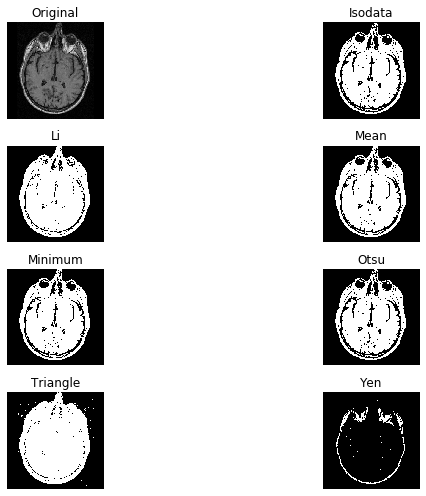

In [4]:
# Display the foreground/background separation of multiple thresholding algorithm
fig, ax = filters.try_all_threshold(brain_im, figsize = (12,7))

The methods above test multiple algorithms to find an optimal threshold. As expected by looking at the histogram above, the algorithms are in general capable of discriminating the background from the foreground (brain+skull). To find the value of the threshold we choose to investigate the otsu threshold algorithm.

Otsu based threshold value is 42


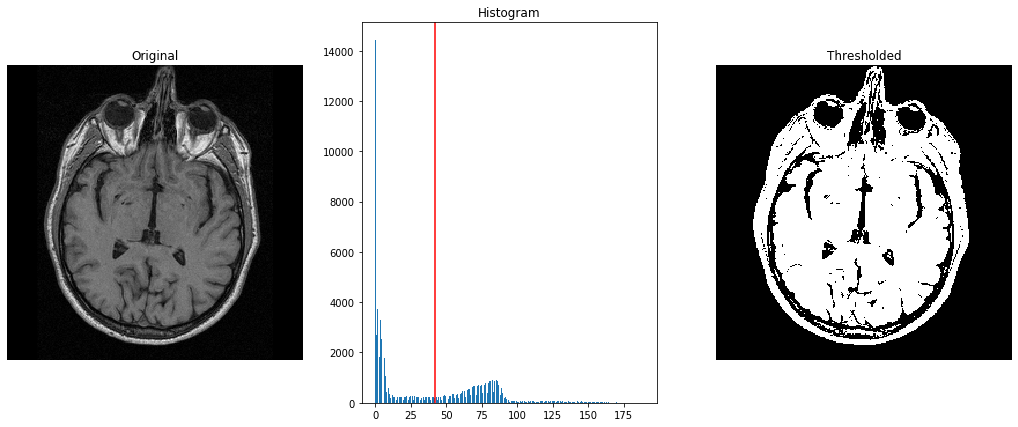

In [5]:
# Use the otsu method provided by sickit-image
thresh = filters.threshold_otsu(brain_im)
print('Otsu based threshold value is {}'.format(thresh))

# Create a binary image based on the threshold find above
binary = brain_im > thresh

# Display the result 
fig, axes = plt.subplots(ncols=3, figsize=(18, 7))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(brain_im.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

The Otsu method confirms our first guess by setting the threshold at a pixel intensity of 42. Therefore the foreground is represented (mainly) by the peak lying between 50 and 100 pixel intensity.

### 1.2 Region growing
The region growing method allows us to define objects by initializing a pixel (seed) and going through its neighbors. The ones that satisfy the homogeineity criterion belong to the same object as the seed, until no more pixel satisfies the criterion in the neighborhood and the object is defined. 
As we want the size of the brain in pixel, we need to be able to discriminate the skull from the brain. However, by looking at the binary image resulting from the binary otsu threshold, we can say that we will not be able to discriminate the skull from the brain using region growing with a single threshold, because the skull and the brain are clearly connected on the binary image. Therefore, the first approach will be to find a second threshold able to discriminate the skull from the brain (multi-threshold approach).

#### Multiotsu algorithm :

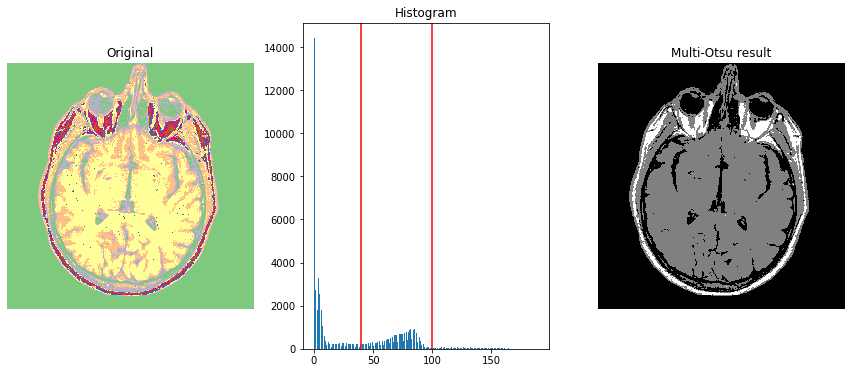

In [6]:
# Apply multi-Otsu threshold for three classes
thresholds = filters.threshold_multiotsu(brain_im)

# Using the threshold values, we generate the three regions.
regions = np.digitize(brain_im, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Plotting the original image.
ax[0].imshow(brain_im, cmap='Accent')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[1].hist(brain_im.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='gray')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

The multiotsu and otsu algorithm rely on minimizing the intra-class variance. In the above method we use this algorithm to split the brain image in three classes: background, skull and brain. The background is still well segmented. However, the skull and the brain are not well segmented, more precisely a part of the skull is segmented as part of the brain and if we use a region growing seed in the brain, we would count the pixels of the skull classified as belonging to the brain leading to an unaccurate result. As we can see on the original image, some areas of the skull are clearly very bright which appears to be gray on the otsu segmentation and some part are darker appears in blue in the otsu image, but they clearly belong to the skull. Therefore, some signal of the skull is overlapping with the brain in the 50-100 pixel intensity region and it would be difficult to separate them by using optimal thresholding algorithm only.

##### Flood_fill algorithm

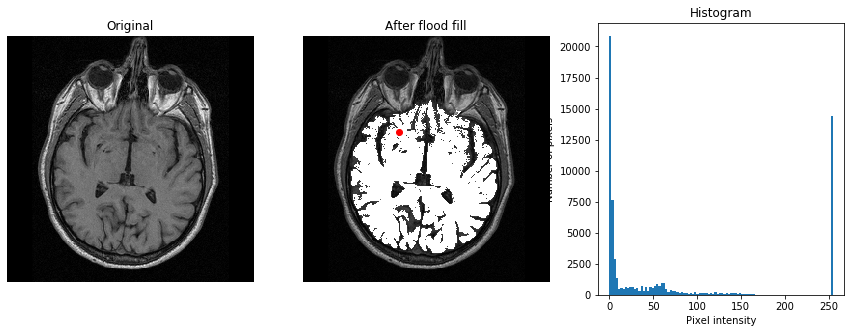

Size in pixels of the brain captured by flod_fill: 14408 pixels


In [7]:
# Set the brain pixel at 255  
# The seed point is chosen as (100, 100),
brain = flood_fill(brain_im, (100, 100), 255, tolerance=16)

# Display the result 
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(brain, cmap=plt.cm.gray)
ax[1].plot(100, 100, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

# Display the associated grayscale histogram
ax[2].hist(brain.ravel(), bins=100)
ax[2].set_title('Histogram')
ax[2].set_xlabel('Pixel intensity')
ax[2].set_ylabel('Number of pixels')

plt.show()

# Count the number of pixels
pix_size = int(brain[brain==255].sum()/255)
print('Size in pixels of the brain captured by flod_fill: {} pixels'.format(pix_size))

The flood_fill method used above allows us to segment the brain from the rest of the image (background + skull). The difference with the previous method  is that the homogeneity criterion is not optimal thresholds, but it relies on a tolerance threshold comparing to the pixel value of the seed. All neighboring pixels in the tolerance are classified as an object. We can see that initializing a seed inside the brain allows us to segment pretty well the brain from the rest of the image, because the cavity between the brain and the skull is dark. The only weakness of the method is the precision at the edges. The tolerance of 16 was found manually and the seed chosen randomly, no doubt that those two parameters can be optimized, but we do not do that here. However, we cannot increase the tolerance much higher, otherwise the edges near the top will connect to the skull as the difference is not that big in pixel intensity. Morever, we used an 8 pixels conectivity criterion otherwise a part at the bottom of the brain would not be included. In conclusion, we got an acceptable estimate of the size of the brain using this region growing method, but for a more precise result others method might be more suitable.

### 1.3 Contour detection

#### Canny edge detector with morphology and flood_fill

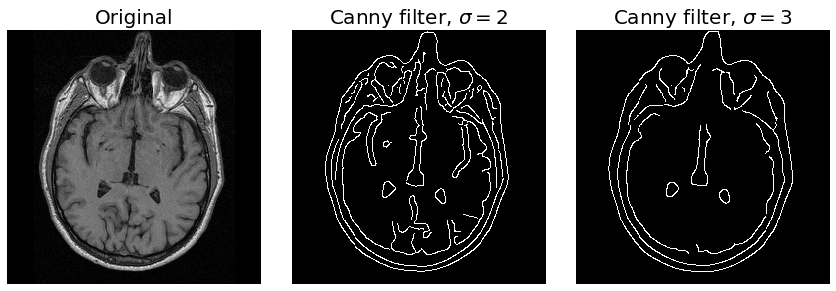

In [8]:
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(brain_im,sigma=2)
edges2 = feature.canny(brain_im, sigma=3)

# Convert the boolean image into a binary (0,1)
edges1_binary = edges1.astype(float)
edges2_binary = edges2.astype(float)

# Display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),sharex=True, sharey=True)

ax1.imshow(brain_im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Original', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=2$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

The Canny edge detector algorithm returns a binary image of the edges in it. First, it applies a smoothing which will blur the details as sigma increases, then calculate the edges by computing the first derivative and finally apply an hysteresis threshold to obtain the binary image. As we can see by increasing the value of sigma, we rapidly loose the details inside the brain. In order to calculate the size of the brain, we use the flood_fill method with a low tolerance which is smaller than one and the seed set inside the brain. However, the edges are not fully connected in both case, so we cannot use it directly. We use the morphological operation of closing to solve this problem.

This time we used a 4 pixels connectivity with flood_fill even if here it would not not change the result. However, edges can be very thin and it is better in that case to use a 4 pixels connectivity to get the size of the brain, all the later use will be with 4.

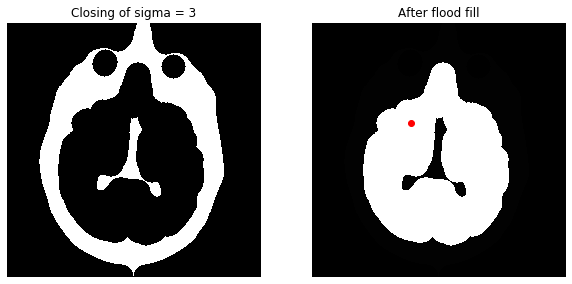

Size in pixels of the brain captured by flod_filling canny closed: 17805 pixels


In [9]:
# Closing the result of canny filtering
canny_closed_3 = closing(edges2_binary,disk(12))
# Set the brain pixels to 125 with a seed inside the brain (100,100)
canny_closed_3_grow = flood_fill(canny_closed_3, (100, 100), 125, connectivity = 1,tolerance =0.1)

# Display the result
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(canny_closed_3, cmap=plt.cm.gray)
ax[0].set_title('Closing of sigma = 3')
ax[0].axis('off')

ax[1].imshow(canny_closed_3_grow, cmap=plt.cm.gray)
ax[1].plot(100, 100, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

plt.show()

# Count the number of pixels
pix_size = int(canny_closed_3_grow[canny_closed_3_grow==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

With sigma equals 3, we already loose some edges that define the brain in the front part. Therefore, we need to close with a big structuring element and we cannot remove the front part which clearly does not belong to the brain. This result is not satisfying and worse than the flood_fill alone. 

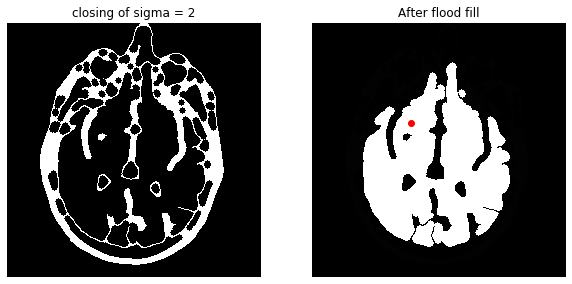

Size in pixels of the brain captured by flod_filling canny closed: 16092 pixels


In [10]:
# Closing the result of canny filtering
canny_closed_2 = closing(edges1_binary,disk(3))
# Set the brain pixels to 125 with a seed inside the brain (100,100)
canny_closed_2_grow = flood_fill(canny_closed_2, (100, 100), 125,connectivity=1,tolerance =0.1)

# Display the result
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(canny_closed_2, cmap=plt.cm.gray)
ax[0].set_title('closing of sigma = 2')
ax[0].axis('off')

ax[1].imshow(canny_closed_2_grow, cmap=plt.cm.gray)
ax[1].plot(100, 100, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

plt.show()

# Count the number of pixels
pix_size = int(canny_closed_2_grow[canny_closed_2_grow==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

With sigma = 2, we do a better job as we loose less details, but we still have some of the front part as above that clearly does not belong to the brain. However, we can recognize the shape of the brain and the size calculated should not be too different from the real one. The parameters used above were not optimized, we just tried some values to obtain an acceptable result. There is no doubt that by optimizing it we could reach a better result, but no tremendous amelioration can be obtained.

#### Roberts, Prewitt and Sobel edge detector filter with morphology and flood_fill

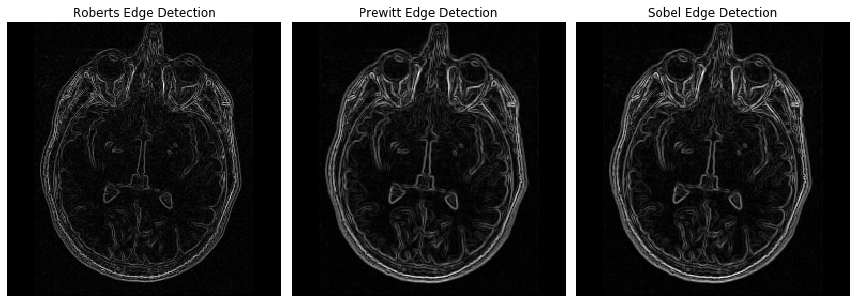

In [11]:
# Compute roberts, prewitt and sobel filters 
edge_roberts = filters.roberts(brain_im)
edge_prewitt = filters.prewitt(brain_im)
edge_sobel = filters.sobel(brain_im)

# Display the result
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(12, 5))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[1].set_title('Prewitt Edge Detection')

ax[2].imshow(edge_sobel, cmap=plt.cm.gray)
ax[2].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

Those three filters implement a finite difference approximation of the first derivative. The images obtained display the edges without thresholding and the edges can take a range of value depending on their slope. Therefore we can see where are the strong and weak edges. We first try to threshold the images to get a binary representation of the edges and do the same as in the Canny's case.

###### sobel :

Otsu based threshold value is 0.07719378486121534


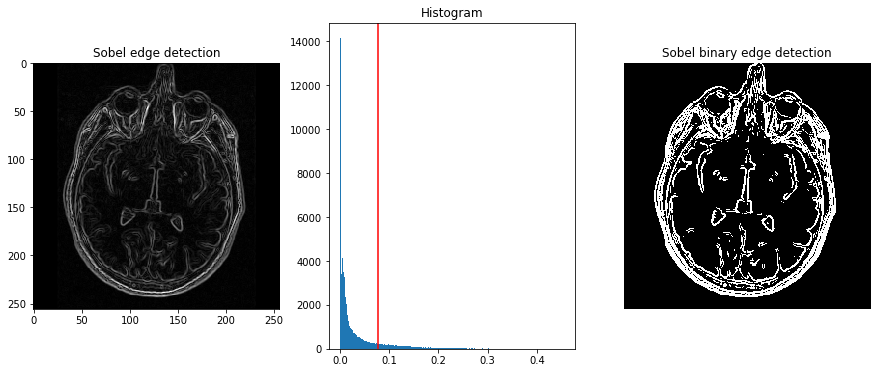

In [12]:
# Use the otsu method provided by sickit-image to threshold the sobel edges
thresh_sobel = filters.threshold_otsu(edge_sobel)
print('Otsu based threshold value is {}'.format(thresh_sobel))

# Create a binary image based on the threshold find above
binary_sobel = edge_sobel > thresh_sobel

# Display the result
fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(edge_sobel, cmap=plt.cm.gray)
ax[0].set_title('Sobel edge detection')

ax[1].hist(edge_sobel.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh_sobel, color='r')

ax[2].imshow(binary_sobel, cmap=plt.cm.gray)
ax[2].set_title('Sobel binary edge detection')
ax[2].axis('off')

plt.show()

Some of the edges are not closed, so we need to use the closing operation.

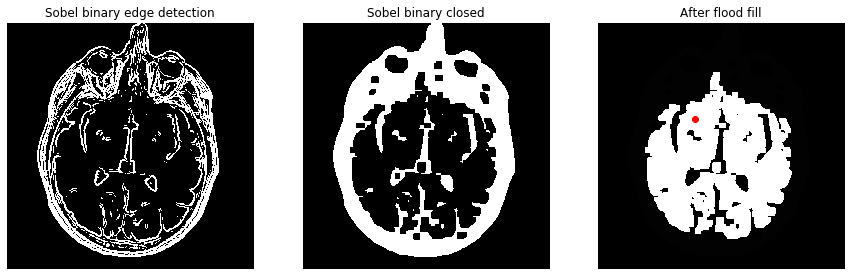

Size in pixels of the brain captured by flod_filling canny closed: 15741 pixels


In [13]:
# Closing the result of sobel binary
binary_sobel_closed = closing(binary_sobel.astype(float),rectangle(5,6))
# Set the brain pixels to 125 with a seed inside the brain (100,100)
binary_sobel_grow = flood_fill(binary_sobel_closed, (100, 100), 125,connectivity=1,tolerance =0.1)

# Display the result 
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))

ax[0].imshow(binary_sobel, cmap=plt.cm.gray)
ax[0].set_title('Sobel binary edge detection')
ax[0].axis('off')

ax[1].imshow(binary_sobel_closed, cmap=plt.cm.gray)
ax[1].set_title('Sobel binary closed')
ax[1].axis('off')

ax[2].imshow(binary_sobel_grow, cmap=plt.cm.gray)
ax[2].plot(100, 100, 'ro')  # seed point
ax[2].set_title('After flood fill')
ax[2].axis('off')

plt.show()

# Count the number of pixels
pix_size = int(binary_sobel_grow[binary_sobel_grow==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

Even if by thresholding and closing we clearly loose the fine details of the contours, we can clearly recognize it. Moreover, we still have the problem at the top of the brain, but it is better than before. The only thing is that some holes of the brain begin to be filled. The result could be improved, here we tested only few structuring element and size.

Next to eliminate the losses due to the tresholding, we use directly flood_fill on the sobel edges image with a very low tolerance.

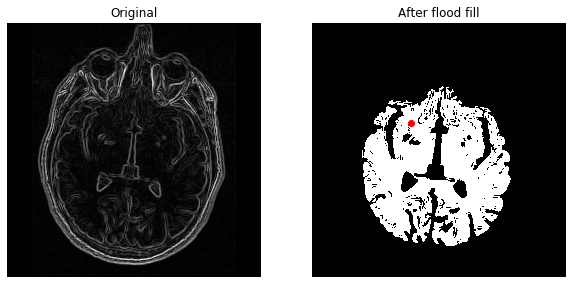

Size in pixels of the brain captured by flod_filling canny closed: 15741 pixels


In [14]:
# Set the brain pixels to 125 with a seed inside the brain (100,100)
sobel_grow = flood_fill(edge_sobel, (100, 100), 125,connectivity=1,tolerance =0.025)

# Display the result
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

ax[0].imshow(edge_sobel, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(sobel_grow, cmap=plt.cm.gray)
ax[1].plot(100, 100, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

plt.show()

# count the number of pixels
pix_size = int(binary_sobel_grow[binary_sobel_grow==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

We are now clearly better on the fines details, no closing  of the contour and we even get rid of the problem with the top of the brain. However, we are now less precise on the inside of the brain with multiples tiny holes which were removed by the the thresholding. We got approximatively the same result as using it on the original image. The result could be tuned as always by trying finer thresholding which was not done here.

A solution for the holes inside can be to use a median filter.

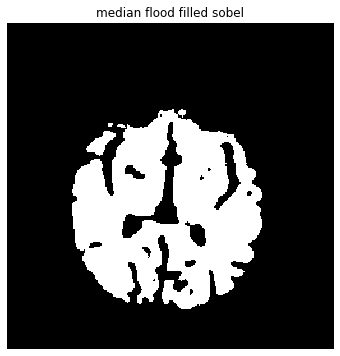

Size in pixels of the brain captured by flod_filling canny closed: 14688 pixels


In [15]:
# Aplly the median filter
sobel_med = filters.median(sobel_grow,disk(3))

# Display the result
fig, ax = plt.subplots(ncols = 1, figsize=(10, 6))

ax.imshow(sobel_med, cmap=plt.cm.gray)
ax.set_title('median flood filled sobel')
ax.axis('off')
plt.show()

# count the number of pixels
pix_size = int(sobel_med[sobel_med==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

We get rid of some of the tiny holes and the size increases.

###### prewitt :

Otsu based threshold value is 0.07442335282191737


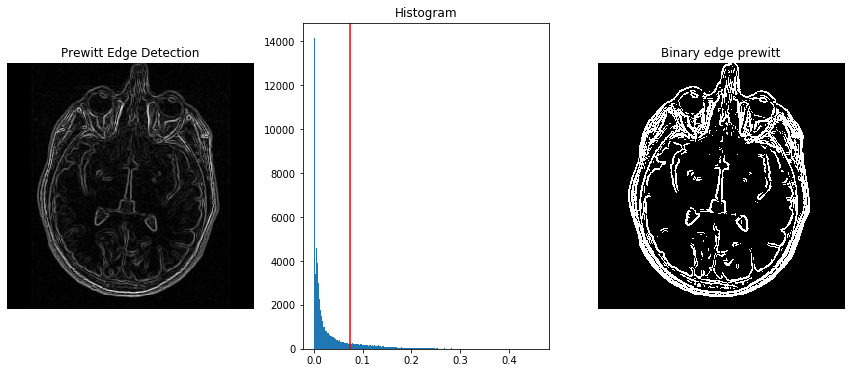

In [16]:
# Use the otsu method provided by sickit-image to threshold the prewitt edges
thresh_prewitt = filters.threshold_otsu(edge_prewitt)
print('Otsu based threshold value is {}'.format(thresh_prewitt))

# Create a binary image based on the threshold find above
binary_prewitt = edge_prewitt > thresh_prewitt

# Display the result 
fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[0].set_title('Prewitt Edge Detection')
ax[0].axis('off')

ax[1].hist(edge_prewitt.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh_prewitt, color='r')

ax[2].imshow(binary_prewitt, cmap=plt.cm.gray)
ax[2].set_title('Binary edge prewitt')
ax[2].axis('off')

plt.show()

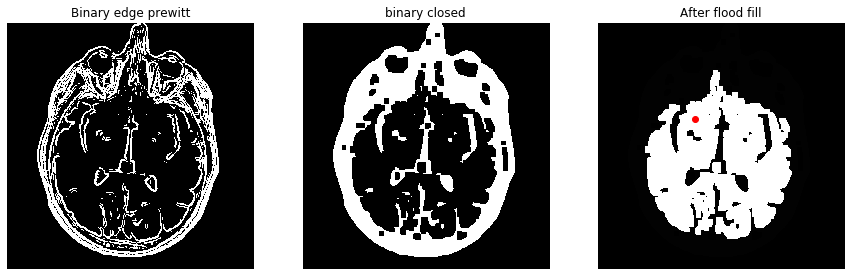

Size in pixels of the brain captured by flod_filling canny closed: 15753 pixels


In [17]:
# Closing the result of prewitt binary
binary_prewitt_closed = closing(binary_prewitt.astype(float),square(5))
# Set the brain pixels to 125 with a seed inside the brain (100,100)
binary_prewitt_grow = flood_fill(binary_prewitt_closed, (100, 100), 125,connectivity=1,tolerance =0.1)

# Display the result
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))

ax[0].imshow(binary_prewitt, cmap=plt.cm.gray)
ax[0].set_title('Binary edge prewitt')
ax[0].axis('off')

ax[1].imshow(binary_prewitt_closed, cmap=plt.cm.gray)
ax[1].set_title('binary closed')
ax[1].axis('off')

ax[2].imshow(binary_prewitt_grow, cmap=plt.cm.gray)
ax[2].plot(100, 100, 'ro')  # seed point
ax[2].set_title('After flood fill')
ax[2].axis('off')

plt.show()

# Count the number of pixels
pix_size = int(binary_prewitt_grow[binary_prewitt_grow==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

The result is similar to sobel's edges as expected. In fact, both implement the finite difference approximation with a eight neighborhood with sobel putting more weight on the 4 connected pixels. Therefore, we do not run the flood_fill directly on the prewitt edge image.  

###### roberts :

Otsu based threshold value is 0.07913621937467473


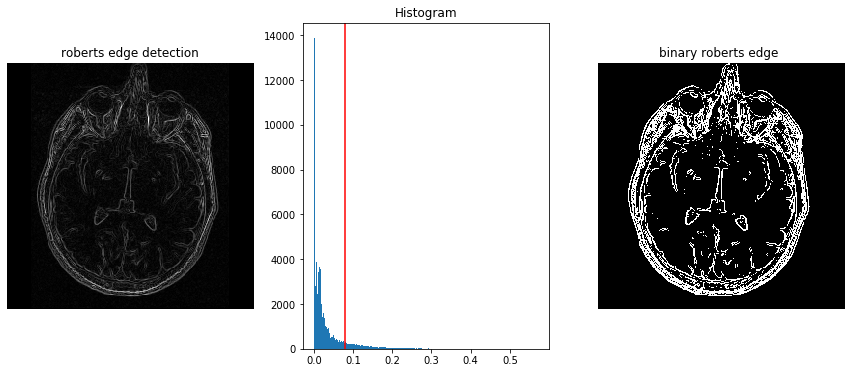

In [18]:
# Use the otsu method provided by sickit-image to threshold the roberts edges
thresh_roberts = filters.threshold_otsu(edge_roberts)
print('Otsu based threshold value is {}'.format(thresh_roberts))

# Create a binary image based on the threshold find above
binary_roberts = edge_roberts > thresh_roberts

# Display the result
fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('roberts edge detection')
ax[0].axis('off')

ax[1].hist(edge_roberts.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh_roberts, color='r')

ax[2].imshow(binary_roberts, cmap=plt.cm.gray)
ax[2].set_title('binary roberts edge ')
ax[2].axis('off')

plt.show()

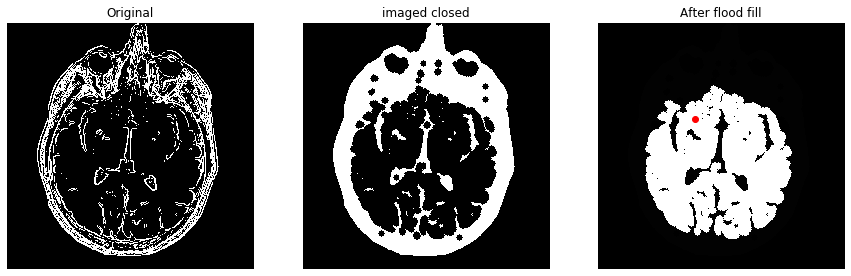

Size in pixels of the brain captured by flod_filling canny closed: 15945 pixels


In [19]:
# Closing the result of roberts binary
binary_roberts_closed = closing(binary_roberts.astype(float),disk(3))
# Set the brain pixels to 125 with a seed inside the brain (100,100)
binary_roberts_grow = flood_fill(binary_roberts_closed, (100, 100), 125,connectivity=1,tolerance =0.1)

# Display the image
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))

ax[0].imshow(binary_roberts, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(binary_roberts_closed, cmap=plt.cm.gray)
ax[1].set_title('imaged closed')
ax[1].axis('off')

ax[2].imshow(binary_roberts_grow, cmap=plt.cm.gray)
ax[2].plot(100, 100, 'ro')  # seed point
ax[2].set_title('After flood fill')
ax[2].axis('off')

plt.show()

# Count the number of pixels
pix_size = int(binary_roberts_grow[binary_roberts_grow==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

The result is pretty similar with prewitt and sobel even if it is a 4 pixels filter instead of 9 for prewitt and sobel.

In conclusion, all three first derivative filters yields approximatively the same result with a brain size between 15'000 and 16'000 pixels.

#### Laplacian of Gaussian (LOG)

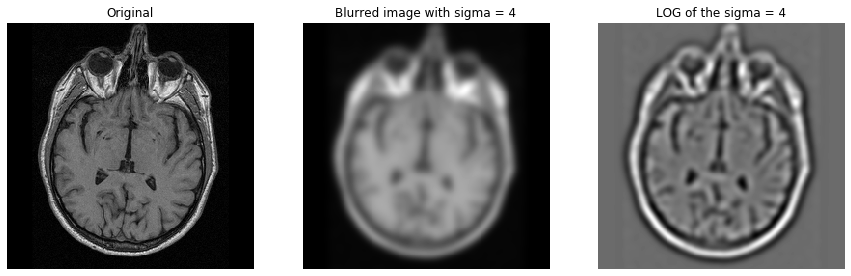

In [20]:
# Gaussian filtering on the original image 
Gaussian_1 = filters.gaussian(brain_im,1)
Gaussian_2 = filters.gaussian(brain_im,4)

# Laplacian of the blurred images
LOG_1 = filters.laplace(Gaussian_1)
LOG_2 = filters.laplace(Gaussian_2)

# Display the result
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(Gaussian_2, cmap=plt.cm.gray)
ax[1].set_title('Blurred image with sigma = 4')
ax[1].axis('off')

ax[2].imshow(LOG_2, cmap=plt.cm.gray)
ax[2].set_title('LOG of the sigma = 4')
ax[2].axis('off')

plt.show()


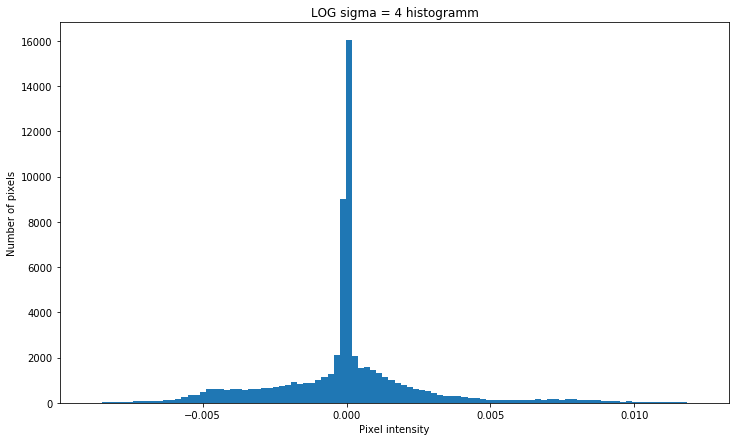

In [21]:
# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(LOG_2.ravel(), bins=100)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('LOG sigma = 4 histogramm')

plt.show()

The histogram of the second derivative is centered in zero and is spread between -0.01 and 0.01 approximatively. The edges are the pixels where the laplacian crosses zero (change of sign). However, not all  the pixels at zero represents a zero crossing and not all the zero crossing pixels are in this peak. In fact, it is rare that a zero crossing pixel has an exact value of 0.0. All the homogeneous region will be at zero as there is no edge so the second derivative is zero. Therefore, we need to detect the zero crossing of the laplacian using an algorithm.

###### First method flood_fill directly on the LOG image sigma = 1

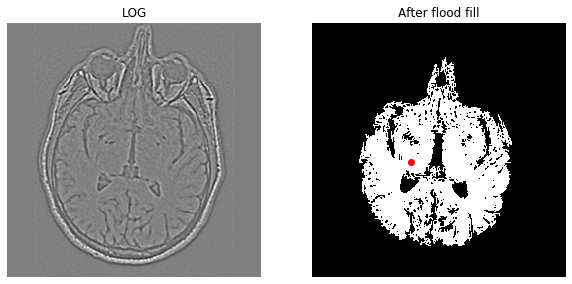

Size in pixels of the brain captured by flod_filling canny closed: 15310 pixels


In [22]:
# Set the brain pixels to 125 with a seed inside the brain (100,140)
LOG_1_grow = flood_fill(LOG_1, (100, 140), 125,connectivity=1,tolerance =0.02)

# Display the result
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(LOG_1, cmap=plt.cm.gray)
ax[0].set_title('LOG')
ax[0].axis('off')

ax[1].imshow(LOG_1_grow, cmap=plt.cm.gray)
ax[1].plot(100, 140, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

plt.show()

# Count the number of pixels
pix_size = int(LOG_1_grow[LOG_1_grow==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

Median filtering

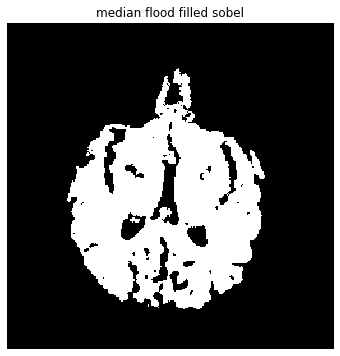

Size in pixels of the brain captured by flod_filling canny closed: 16027 pixels


In [23]:
# Apply the median filter
LOG_1__med = filters.median(LOG_1_grow, disk(2))

# Display the result
fig, ax = plt.subplots(ncols = 1, figsize=(10, 6))

ax.imshow(LOG_1__med, cmap=plt.cm.gray)
ax.set_title('median flood filled sobel')
ax.axis('off')
plt.show()

# Count the number of pixels
pix_size = int(LOG_1__med[LOG_1__med==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

Even if the laplacian does not detect the edges directly as for the first derivative, but by the zero crossing of it, we can achieve reasonable result by flood_filling  at a right seed. In fact, the laplacian will vary only close to the edges and remain zero far from it. Therefore, it is a little bit less precise than for sobel above, but by picking an adequate tolerance we got an acceptable result apart from the top where the two "corns" appear.

###### Zero-crossing algorithm  :

In [24]:
# Find the zero crossing in the log image
def z_c_detector(log_image,threshold):
    z_c_image = np.zeros(log_image.shape)
    

    # Check the sign (negative or positive) of all the pixels around each pixel (8 connectivity)
    for i in range(1,log_image.shape[0]-1):
        for j in range(1,log_image.shape[1]-1):
            neg_count = 0
            pos_count = 0
            max_pixel = 0.0
            min_pixel = 0.0 
            # go through the neighborhood of the pixel 
            for a in range(-1, 2,1):
                for b in range(-1,2,1):
                    if(a != 0 and b != 0):
                        if(log_image[i+a,j+b] < min_pixel):
                            min_pixel = log_image[i+a,j+b]
                        if(log_image[i+a,j+b] > max_pixel):
                            max_pixel = log_image[i+a,j+b]
                        if(log_image[i+a,j+b] < 0.0):
                            neg_count += 1
                        elif(log_image[i+a,j+b] > 0.0):
                            pos_count += 1
            delta = max_pixel- min_pixel
            # If all the signs around the pixel are the same and they're not all zero, then it's not a zero crossing and not an edge. 
            # If the difference between the max and the min value is less than the threshold not an edge
            # Otherwise, copy it to the edge map.
            z_c = ( (neg_count > 0) and (pos_count > 0) and (delta >threshold) )
            if(z_c):
                z_c_image[i,j] = 1

    return z_c_image


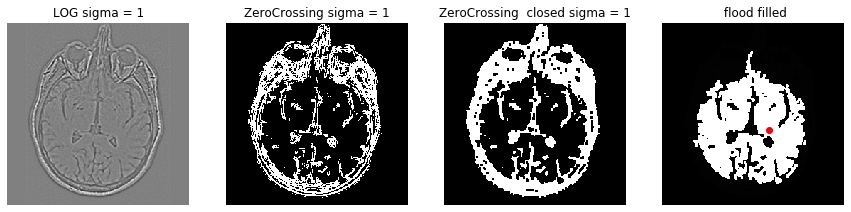

Size in pixels of the brain captured by flod_filling canny closed: 15463 pixels


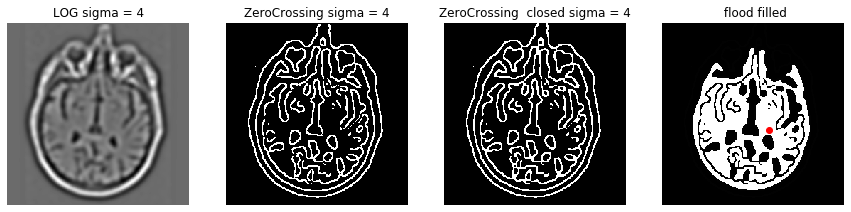

Size in pixels of the brain captured by flod_filling canny closed: 16314 pixels


In [25]:
# Apply the zero crossing algorithm with thresholding on the laplacian
ZeroCrossing1 = z_c_detector(LOG_1,0.05)
# Close the zero crossing image
ZeroCrossing_closing1 = closing(ZeroCrossing1, square(3))
# Set the brain pixels to 125 with a seed inside the brain (150,150)
ZeroCrossing_grow1 = flood_fill(ZeroCrossing_closing1, (150, 150), 125, connectivity=1,tolerance =0.1)

# Display the result
fig, ax = plt.subplots(ncols=4, figsize=(15, 10))

ax[0].imshow(LOG_1, cmap=plt.cm.gray)
ax[0].set_title('LOG sigma = 1')
ax[0].axis('off')

ax[1].imshow(ZeroCrossing1, cmap=plt.cm.gray)
ax[1].set_title('ZeroCrossing sigma = 1')
ax[1].axis('off')

ax[2].imshow(ZeroCrossing_closing1, cmap=plt.cm.gray)
ax[2].set_title('ZeroCrossing  closed sigma = 1')
ax[2].axis('off')

ax[3].imshow(ZeroCrossing_grow1, cmap=plt.cm.gray)
ax[3].plot(150, 150, 'ro')  # seed point
ax[3].set_title(' flood filled')
ax[3].axis('off')

plt.show()

# count the number of pixels
pix_size = int(ZeroCrossing_grow1[ZeroCrossing_grow1==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))

# Apply the zero crossing algorithm with thresholding on the laplacian
ZeroCrossing2 = z_c_detector(LOG_2,0.001)
# Close the zero crossing image
ZeroCrossing_closing2 = closing(ZeroCrossing2, square(3))
# Set the brain pixels to 125 with a seed inside the brain (150,150)
ZeroCrossing_grow2 = flood_fill(ZeroCrossing_closing2, (150, 150), 125, connectivity=1,tolerance =0.1)
# Display the result
fig, ax = plt.subplots(ncols=4, figsize=(15, 10))

ax[0].imshow(LOG_2, cmap=plt.cm.gray)
ax[0].set_title('LOG sigma = 4')
ax[0].axis('off')

ax[1].imshow(ZeroCrossing2, cmap=plt.cm.gray)
ax[1].set_title('ZeroCrossing sigma = 4')
ax[1].axis('off')

ax[2].imshow(ZeroCrossing_closing2, cmap=plt.cm.gray)
ax[2].set_title('ZeroCrossing  closed sigma = 4')
ax[2].axis('off')

ax[3].imshow(ZeroCrossing_grow2, cmap=plt.cm.gray)
ax[3].plot(150, 150, 'ro')  # seed point
ax[3].set_title(' flood filled')
ax[3].axis('off')

plt.show()

# Count the number of pixels
pix_size = int(ZeroCrossing_grow2[ZeroCrossing_grow2==125].sum()/125)
print('Size in pixels of the brain captured by flod_filling canny closed: {} pixels'.format(pix_size))


The zerocrossing of the LOG combined with a simple threshold allows us to detect pretty well the edges and get rid of most of the noise (small fluctuations of the signal in the image between too similar pixels which is detected as an edge in the LOG) especially if we smooth high enough the image. Indeed, even if smoothing gets rid of part of the noise, we can not smooth too much otherwise we loose the edges, so some residual noise persist in the LOG image which we get rid of with the thresholding in the zero crossing. However, by combining both the resulting edges are not fully closed (sigma =4), some of the weak and/or fine edges disappear and even by closing we are not able to get rid of the space between the skull and the brain. On the contrary, by smoothing a litlle bit (sigma =1), applying a high threshold and closing we are able to segment only the brain. In conclusion, the LOG is a very sensitive technique and to obtain a well segmented images with flood fill, it surely must be optimized and not be investigated manually as here. Moreover a better threshold technique should probably be implemented.

### 1.4 Additional method(s)

#### Active contour
Based on : https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_morphsnakes.html#sphx-glr-auto-examples-segmentation-plot-morphsnakes-py

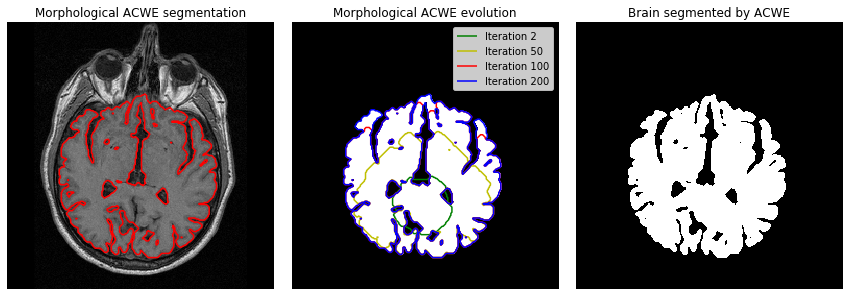

Size in pixels of the brain captured by the active contour method: 15726 pixels


In [26]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Initial level set
init_ls = circle_level_set(brain_im.shape,center = (175,125), radius = 27)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)

# Level sets active contour method 
ls = morphological_chan_vese(brain_im, 250, init_level_set=init_ls, smoothing=1, lambda1 = 190, lambda2 = 50,
                             iter_callback=callback)

# Display the result
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
ax = axes.flatten()

ax[0].imshow(brain_im, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[50], [0.5], colors='y')
contour.collections[0].set_label("Iteration 50")
contour = ax[1].contour(evolution[100], [0.5], colors='r')
contour.collections[0].set_label("Iteration 100")
contour = ax[1].contour(evolution[200], [0.5], colors='b')
contour.collections[0].set_label("Iteration 200")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)

ax[2].imshow(ls, cmap='gray')
ax[2].set_title('Brain segmented by ACWE', fontsize = 12)
ax[2].axis('off')

fig.tight_layout()
plt.show()

# Count the number of pixels
pix_size = int(ls[ls==1].sum()/1)
print('Size in pixels of the brain captured by the active contour method: {} pixels'.format(pix_size))

The Chan-Vese active contours algorithm used above gives us the bust result so far, it is able to segment the brain almost perfectly and preserve the details of the contour. Therefore, the size of the brain is approximatively 15'500 pixels.

As for all active contours methods, this algorithm relies on minimizing an energy functional. However, this energy is not based on matching edges through the inverse of the gradient, as seen in the course, or other implementation. The initialized level sets evolves iteratively through minimizing the weighted sum of the difference in intensity from the average inside and outside the region respectively. Therefore, it would not suffer from the problem we got with the gradient in the previous algorithm. The weights are represented by lambda1 and lambda2 above. Moreover, it uses an approximation of the solution of the partial differential equations through morphological operators, so no gradient descent is involved and no step size tuning is necessary. The classical Chan-Vese algorithm was used and the results were worth as we do not get rid of part of the skull.

All parameters and the initialization of the initial level sets were found manually.

#### Region-based segmentation : Watershed 

Based on: https://scikit-image.org/docs/dev/auto_examples/applications/plot_coins_segmentation.html#sphx-glr-auto-examples-applications-plot-coins-segmentation-py

Watershed is an often used region-based segmentation defined on grayscale images. This transformation treats the image like a topographic map, that was in our case based on the Sobel gradient of the image, meaning that the watershed lines were defined by the edges. However the filter was not applied directly on the original image, but on the image after a flood fill, which yielded better results. Then, the markers were defined by hand in order to apply the watershed algorithm. The algorithm then uses pixels values of the topographic map fo fill the different regions, starting from the markers that we defined. 

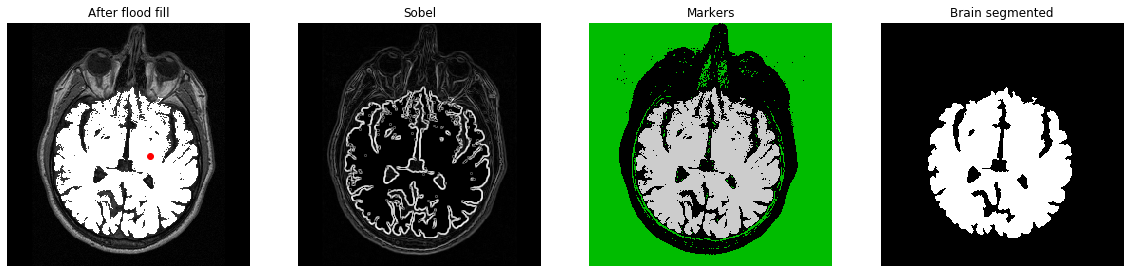

In [27]:
# Perform a flood fill before Sobel filter
brain_ff = flood_fill(brain_im, (150, 140), 255, tolerance=17)
sobel_gradient = filters.sobel(brain_ff)

# Set the markers for watershed 
markers = np.zeros_like(brain_im)  
markers[brain < 15] = 1
markers[brain > 200] = 2

# Perform watershed
segm = morphology.watershed(sobel_gradient, markers)

# Display the results
fig, ax = plt.subplots(ncols=4, figsize=(20, 8))

ax[0].imshow(brain_ff, cmap=plt.cm.gray)
ax[0].plot(150, 140, 'ro')  # seed point
ax[0].set_title('After flood fill')
ax[0].axis('off')

ax[1].imshow(sobel_gradient, cmap=plt.cm.gray)
ax[1].set_title('Sobel')
ax[1].axis('off')

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Markers')
ax[2].axis('off')

ax[3].imshow(segm, cmap=plt.cm.gray)
ax[3].set_title('Brain segmented')
ax[3].axis('off')

plt.show()

In [28]:
# Count the number of pixels
brain_pix = int(segm[segm==2].sum()/2)
print('Size in pixels of the brain captured by flod_fill: {} pixels'.format(brain_pix))

Size in pixels of the brain captured by flod_fill: 15735 pixels


The obtained result of 15735 pixels for the brain size is very similar to the one yielded by active contours (15726 pixels), which confirms the conclusion above about the brain size. Visually, the segmented brain is rather correct and as can be seen details are quite well segmented.

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [29]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


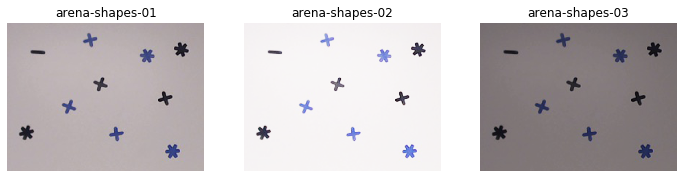

In [30]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color

##### Display grayscale images and histograms

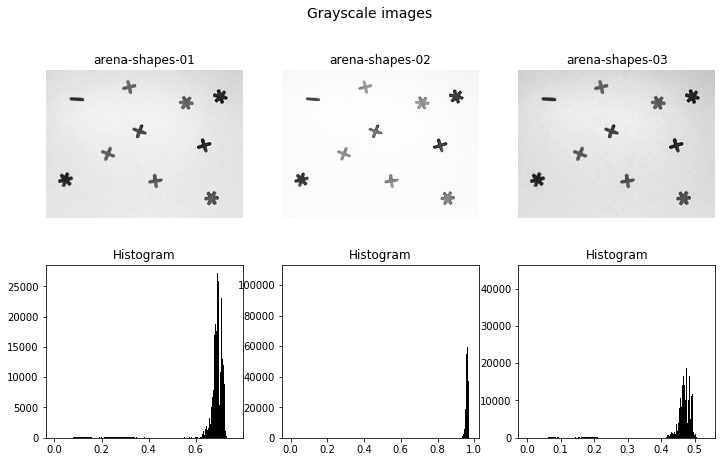

In [31]:
# Check grayscale images

fig, ax = plt.subplots(2,3, figsize=(12, 7))
for ind, im, nm in zip(range(3), images, im_names):
    gi = skimage.color.rgb2gray(im)
    ax[0,ind].imshow(gi, cmap='gray')
    ax[0,ind].set_title(nm)
    ax[0,ind].axis('off')
        
    ax[1,ind].hist(gi.ravel(), bins=255, color='black')
    ax[1,ind].set_title('Histogram')

fig.suptitle('Grayscale images', fontsize=14)
plt.show()

From the histograms, we can see that there is a large peak, which supposedly corresponds to the background, but for now we cannot differenciate the blue shapes from the black ones. 

##### Display each channel (RGB) separately

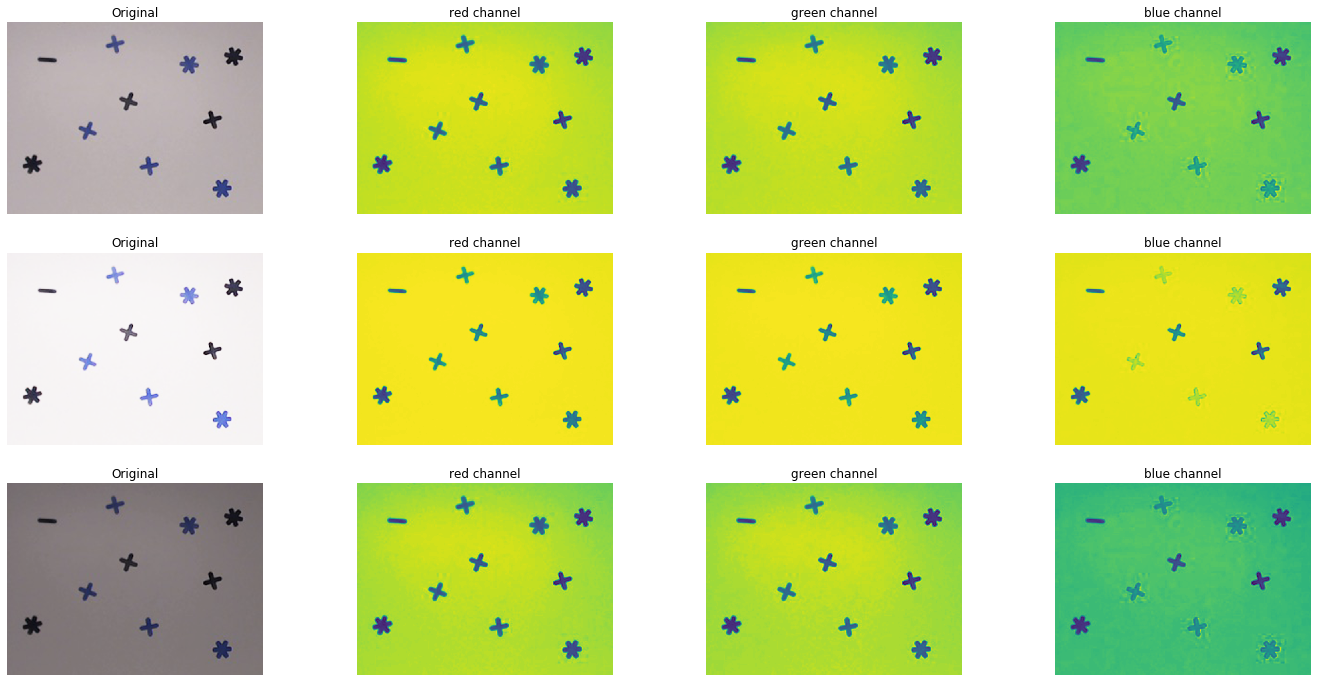

In [32]:
# Check if the difference between blue and black shapes is stronger in separated channels

fig, ax = plt.subplots(3,4, figsize=(24, 12))
for ind, im in zip(range(3), images):
    ax[ind,0].imshow(im)
    ax[ind,0].set_title('Original')
    ax[ind,0].axis('off')
        
    ax[ind,1].imshow(im[:,:,0])
    ax[ind,1].set_title('red channel')
    ax[ind,1].axis('off')
    
    ax[ind,2].imshow(im[:,:,1])
    ax[ind,2].set_title('green channel')
    ax[ind,2].axis('off')
        
    ax[ind,3].imshow(im[:,:,2])
    ax[ind,3].set_title('blue channel')
    ax[ind,3].axis('off')

plt.show()

From this separation, we see that it is easier to differentiate the blue from the black shapes on the blue channel. Therefore, we decided to use this channel to apply the following operations.

##### Exposure modification 

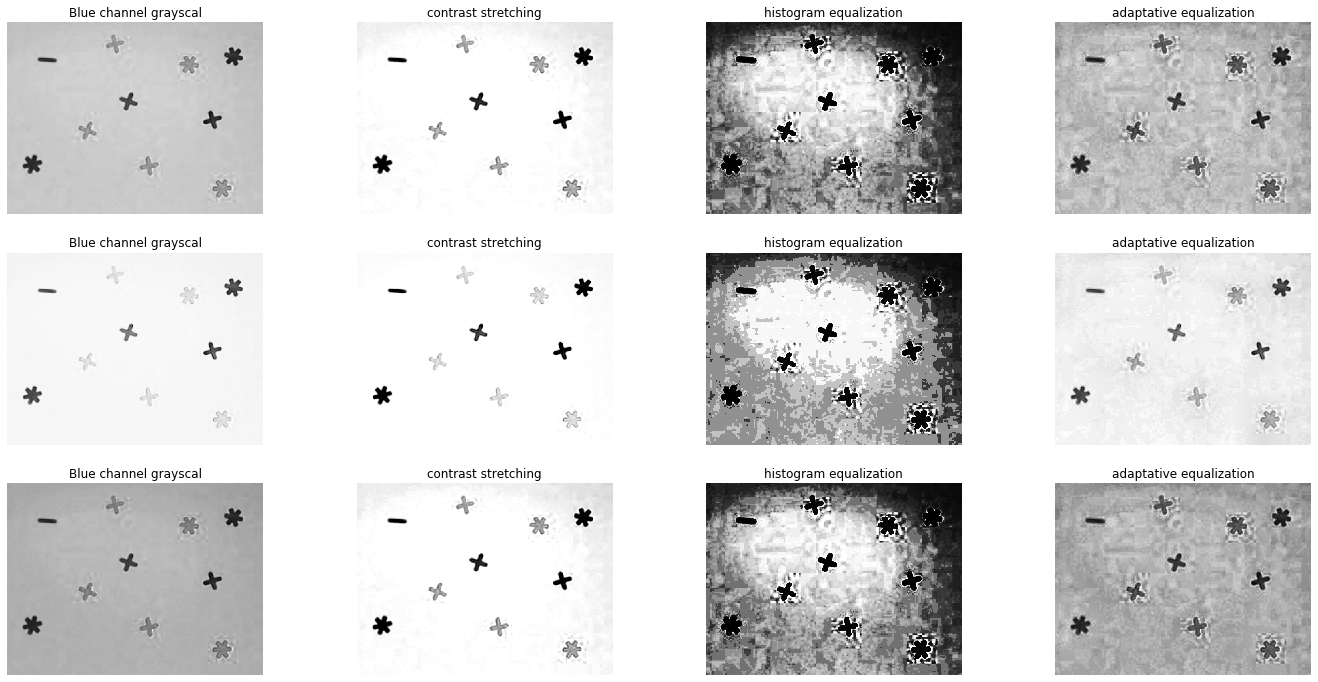

In [33]:
# Test different operations on the Histogram

rescale_im = []

fig, ax = plt.subplots(3,4, figsize=(24, 12))
for ind, im in zip(range(3), images):
    
    #modify exposure of blue channel since the difference is more visible there
    img = skimage.color.rgb2gray(im[:,:,2])
    
    # Contrast stretching
    a, b = np.percentile(img, (0.8, 50))
    img_rescale = exposure.rescale_intensity(img, in_range=(a, b))
    
    # Equalization
    img_eq = exposure.equalize_hist(img)
    
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    ax[ind,0].imshow(img, cmap='gray')
    ax[ind,0].set_title('Blue channel grayscal')
    ax[ind,0].axis('off')
        
    ax[ind,1].imshow(img_rescale, cmap='gray')
    ax[ind,1].set_title('contrast stretching')
    ax[ind,1].axis('off')
    
    ax[ind,2].imshow(img_eq, cmap='gray')
    ax[ind,2].set_title('histogram equalization')
    ax[ind,2].axis('off')
        
    ax[ind,3].imshow(img_adapteq, cmap='gray')
    ax[ind,3].set_title('adaptative equalization')
    ax[ind,3].axis('off')
    
    rescale_im.append(img_rescale)

plt.show()

We apply different operations on the histogram of the grayscale images of the blue channel. The first method we tried is contrast stretching which stretches/shrinks between a range of values the intensity levels of the input image. Before this operations the peaks corresponding to the shapes were too flat to bee separated, now they are more visible (see next). We also tried two methods based on histogram equalization which creates an image with a uniform histogram. From the images displayed above we see that contrast stretching works well and that the two colors are more distinguishable from each other. 

##### Thresholding : multi-otsu method

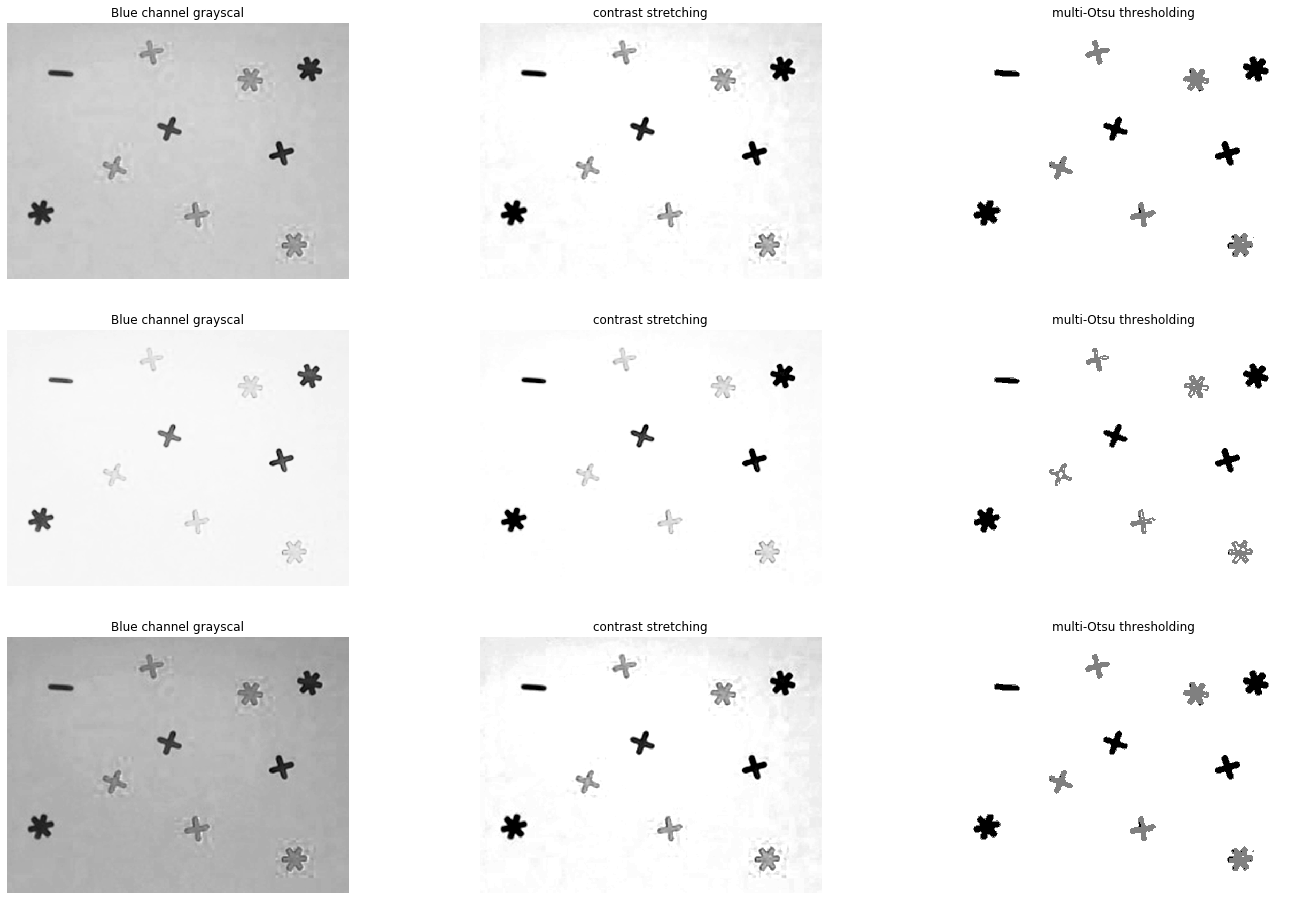

In [34]:
digitized = []
threshold = []

fig, ax = plt.subplots(3,3, figsize=(24, 16))
for ind, im, res in zip(range(3), images, rescale_im):
    
    img = skimage.color.rgb2gray(im[:,:,2])
    
    ax[ind,0].imshow(img, cmap='gray')
    ax[ind,0].set_title('Blue channel grayscal')
    ax[ind,0].axis('off')
        
    ax[ind,1].imshow(res, cmap='gray')
    ax[ind,1].set_title('contrast stretching')
    ax[ind,1].axis('off')
    
    # Applying multi-Otsu threshold for the default value, generating
    # three classes.
    thresholds = threshold_multiotsu(res)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(res, bins=thresholds)
    
    ax[ind,2].imshow(regions, cmap='gray')
    ax[ind,2].set_title('multi-Otsu thresholding')
    ax[ind,2].axis('off')
    
    digitized.append(regions)
    threshold.append(thresholds)

plt.show()

We apply the multi-otsu method on the images obtained after contrast stretching. This algorithm return us two thresholds which allow us to map the images values into three values (0 for the black shapes, 1 for the blues shapes and 2 for the background). In the next plot we show how the method is applied on the histogram to find the best thresholds. 

##### multi-otsu histograms and thresholds

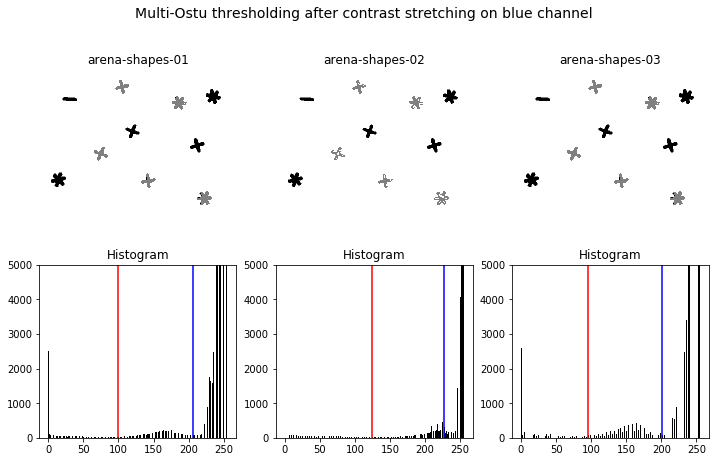

In [35]:
fig, ax = plt.subplots(2,3, figsize=(12, 7))
for ind, res, dig, thresh, nm in zip(range(3), rescale_im, digitized, threshold, im_names):

    thresholds = thresh
    ax[0,ind].imshow(dig, cmap='gray')
    ax[0,ind].axis('off')
    ax[0,ind].set_title(nm)
    ax[1,ind].hist(res.ravel(), bins=255, color='black')
    ax[1,ind].set_title('Histogram')
    ax[1,ind].set_ylim(0, 5000)
    ax[1,ind].axvline(thresholds[0], color='r')
    ax[1,ind].axvline(thresholds[1], color='b')

fig.suptitle('Multi-Ostu thresholding after contrast stretching on blue channel', fontsize=14)    
plt.show()

As we can see on the histogram plots above, the thresholds returned by the multi-otsu algorithm separate the different peaks, corresponding to the black shapes on the left, the blue shapes in the middle and the background in the right, quite efficiently. This discretization will allow us to separate blue shapes from black shapes into binary images

##### Shapes separation

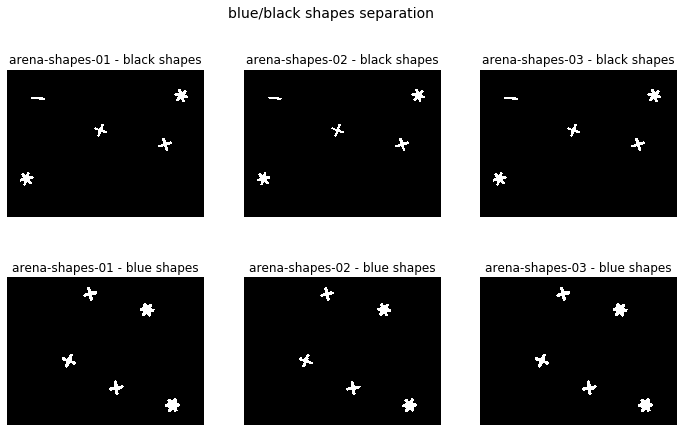

In [36]:
# Blue / black shapes separation

blueshapes = []
blackshapes = []

fig, ax = plt.subplots(2,3, figsize=(12,7))
for ind, dig, thresh, nm in zip(range(3), digitized, threshold, im_names):
    
    blackpts = dig == 0
    erodeblk = morphology.binary_closing(blackpts, skimage.morphology.selem.disk(5))
    test = morphology.binary_erosion(blackpts, skimage.morphology.selem.disk(1))
    blackshapes.append(test)
    
    bluepts = dig == 1
    closeblue = morphology.area_opening(bluepts, 350)
    check = morphology.binary_closing(closeblue, skimage.morphology.selem.disk(3))
    blueshapes.append(check)

    ax[0,ind].imshow(test, cmap='gray')
    ax[0,ind].set_title(nm+' - black shapes')
    ax[0,ind].axis('off')
    ax[1,ind].imshow(check, cmap='gray')
    ax[1,ind].set_title(nm+' - blue shapes')
    ax[1,ind].axis('off')

fig.suptitle('blue/black shapes separation', fontsize=14)    
plt.show()

Since the images are now only composed of three values (0 for the black pixels, 1 for the blues pixels and 2 for the background), it is easy to separate each image into two binary images (one for blue pixels, another for black pixels). We also apply morphological operators (opening/closing/erosion) to obtain the images displayed above. These operators will remove the pixels that are not connected to one of the shapes which results in binary images where pixels that are "True" necessarily belong to a shape. We will confirm that in the following. 

##### Count the number of shapes of each color

In [37]:
# Number of shapes of each color
for blue, black, nm in zip(blueshapes, blackshapes, im_names):
    shapebk = label(erosion(black, disk(2)), return_num=True)[1]
    shapebe = label(blue, return_num=True)[1]
    print('{n} : The number of blue shapes is {be} and the number of black shapes is {bk}'.format(n=nm, be=shapebe, bk=shapebk))

arena-shapes-01 : The number of blue shapes is 5 and the number of black shapes is 5
arena-shapes-02 : The number of blue shapes is 5 and the number of black shapes is 5
arena-shapes-03 : The number of blue shapes is 5 and the number of black shapes is 5


After all these operations, we can finally count the number of shapes of each color. We use the skimage function label (in the measure module) which returns the number of connected regions in an image. In this algorithm, two pixels are connected if they are neighbors and have the same value. From the results above, we see that each image has 5 shapes which confirm that the previous operations worked well. 

### 2.3 Total area (in pixels) of each color

In [38]:
# Number of pixels of each color
for blue, black, nm in zip(blueshapes, blackshapes, im_names):
    bluepixels = (blue==True).sum()
    blackpixels = (black==True).sum()
    print('{n} : The number of blue pixels is {be} and the number of black pixels is {bk}'.format(n=nm, be=bluepixels, bk=blackpixels))

arena-shapes-01 : The number of blue pixels is 5285 and the number of black pixels is 3782
arena-shapes-02 : The number of blue pixels is 4768 and the number of black pixels is 3532
arena-shapes-03 : The number of blue pixels is 5327 and the number of black pixels is 3782


Since we already separated each image into two binary images, one for blue pixels and another one for black pixels, it is really easy to count the number of pixels for each color. We just count the number of values set to "True" in each images. From the results displayed, we can see that our routine is quite efficient. We have  approximately the same number of pixels for each image. But still, there is a small dfference between the second image and the others. That is expected since the illumination on this image is really different from the two others which means that our routine could be optimized to be even more robust. 